## MLP class:  relu, XE

2 hidden layers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.default_rng()

In [8]:
''' define  layers '''

# Fully connected layer
class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.weights = rng.normal(0,1,[input_size, output_size]) * np.sqrt(2.0 / input_size)
        self.bias = np.zeros([output_size,1])

    def forward(self, X):
        self.X = X
        out = np.matmul(self.weights.T, X) + self.bias
        return out

    def backward(self, d_out, learning_rate):
        dW = np.matmul(self.X, d_out.T)
        db = np.sum(d_out, axis=1, keepdims = True)
        dX = np.matmul(self.weights, d_out)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        return dX

    # ReLU activation layer
class ReLU:
    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out

    def backward(self, d_out):
        d_out[self.mask] = 0
        return d_out


# Softmax loss layer
class SoftmaxLoss:
    def forward(self, X, y):
        self.y = y
        exp_scores = np.exp(X - np.max(X, axis=0, keepdims=True))
        self.probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
        loss =  - np.sum(y*np.log(self.probs))
        return loss

    def backward(self):
        dX = -(self.y - self.probs)
        return dX


'''Define MLP model'''

class MLP:
    def __init__(self, nx, nh1,nh2, ny):
        self.nx = nx
        self.nh1 = nh1
        self.nh2 = nh2
        self.ny = ny
        self.fc1 = FullyConnectedLayer(self.nx,self.nh1) 
        self.relu1 = ReLU()
        self.fc2 = FullyConnectedLayer(self.nh1,self.nh2) 
        self.relu2 = ReLU()
        self.fc3 = FullyConnectedLayer(self.nh2,self.ny)
        self.loss = SoftmaxLoss()

    def forward(self, X):
        out = self.fc1.forward(X)
        out = self.relu1.forward(out)
        out = self.fc2.forward(out)
        out = self.relu2.forward(out)
        out = self.fc3.forward(out)
        return out

    def backward(self, d_out, learning_rate):
        d_out = self.fc3.backward(d_out, learning_rate)
        d_out = self.relu2.backward(d_out)
        d_out = self.fc2.backward(d_out, learning_rate)
        d_out = self.relu1.backward(d_out)
        d_out = self.fc1.backward(d_out, learning_rate)
        return d_out

'''Train the MLP model'''
    
def train_model(model, X_train, Y_train, learning_rate, num_epochs, batch_size):
    num_examples = X_train.shape[1]
    num_batches = num_examples // batch_size

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_train[:,start:end]
            Y_batch = Y_train[:,start:end]

            # Forward pass
            output = model.forward(X_batch)
            loss = model.loss.forward(output, Y_batch)
            epoch_loss += loss

            # Backward pass
            d_out = model.loss.backward()
            model.backward(d_out, learning_rate)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

In [9]:
'''read the data'''

# Specify the path to the CSV file
path_train = 'data/MNIST_train_1000.csv'
path_test = 'data/MNIST_test_100.csv'


data_train = np.genfromtxt(path_train, delimiter=',', skip_header=0, dtype=int)
data_test = np.genfromtxt(path_test, delimiter=',', skip_header=0, dtype=int)

m,m1 = data_train.shape[0], data_test.shape[0]

'''
get the training and test split and one-hot embedding of labels 

notice that each example is a column
'''

X_train = data_train[:,1:].T/255
Y_train = np.eye(10)[:,data_train[:,0]]
X_test = data_test[:,1:].T/255
Y_test = np.eye(10)[:, data_test[:,0] ]

nx = X_train.shape[0]
ny = Y_train.shape[0]
nh1, nh2 = 100, 100

In [10]:
'''define and train the model: providing hyperparameters'''

model = MLP(nx,nh1,nh2,ny)
train_model(model, X_train, Y_train, learning_rate= 0.01, num_epochs=100, batch_size=32)

Epoch 1/100, Loss: 1339.6251644958236
Epoch 2/100, Loss: 757.7726462954336
Epoch 3/100, Loss: 371.29001196182514
Epoch 4/100, Loss: 183.94179709872745
Epoch 5/100, Loss: 93.69725926193809
Epoch 6/100, Loss: 62.32224950261924
Epoch 7/100, Loss: 56.34836943861436
Epoch 8/100, Loss: 30.352407096790344
Epoch 9/100, Loss: 16.911626922195502
Epoch 10/100, Loss: 9.677624502664168
Epoch 11/100, Loss: 6.625389030741973
Epoch 12/100, Loss: 5.110891119524681
Epoch 13/100, Loss: 4.268050161046474
Epoch 14/100, Loss: 3.661136099591891
Epoch 15/100, Loss: 3.209726330537314
Epoch 16/100, Loss: 2.8624814734988955
Epoch 17/100, Loss: 2.5792197843177704
Epoch 18/100, Loss: 2.352296496154423
Epoch 19/100, Loss: 2.1544803976958415
Epoch 20/100, Loss: 1.9925262815514417
Epoch 21/100, Loss: 1.8493818960672965
Epoch 22/100, Loss: 1.7252947225355546
Epoch 23/100, Loss: 1.6145853619602437
Epoch 24/100, Loss: 1.5167638535946775
Epoch 25/100, Loss: 1.432376342315145
Epoch 26/100, Loss: 1.354992422004483
Epoch 27

# Test: 88%

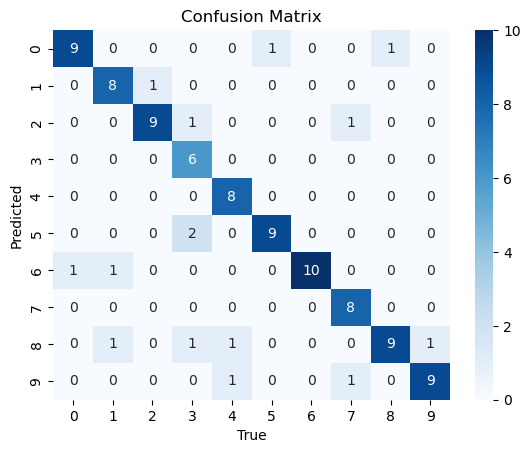

85

In [11]:
'''Forward pass the test data '''

output = model.forward(X_test)
probas = np.exp(output)/np.sum(np.exp(output), axis = 0, keepdims = True)
pos =  np.argmax(probas, axis =0)
y_pred = np.zeros_like(probas)
y_pred[pos,range(y_pred.shape[1])] = 1

''' compute the confusion matirx '''
confusion = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        confusion[i,j] = np.dot(y_pred[i],Y_test[j])

''' heatmap '''       

confusion_int = confusion.astype(int)

sns.heatmap(confusion_int, annot = True, fmt='d', cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

''' accuracy '''
np.trace(confusion_int)